In [1]:
import numpy as np
from sklearn.datasets import load_digits
import gtda.homology
import gtda.diagrams
import matplotlib.pyplot as plt
from  sklearn.preprocessing import StandardScaler
from skimage import filters
from scipy.signal import convolve2d

In [2]:
#Load data
digits = load_digits()
X = digits.data
X = np.reshape(X,(1797,8,8))

(44925, 4, 4)
[0.16609951 0.15618705 0.11817766 0.10800606 0.08777139 0.07112392
 0.05550198 0.04673085 0.03995888 0.03654383 0.02770174 0.02415124
 0.01962616 0.01852151 0.0147113  0.00918692]


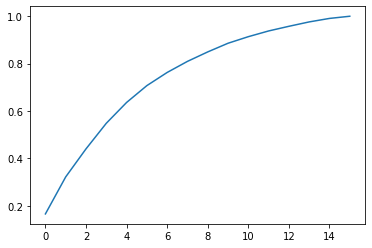

In [92]:
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA 
patches = []
for im in X:
    patches.extend(extract_patches_2d(im,(4,4)))
print(np.shape(patches))
patches = np.reshape(patches,(44925,16))
pca = PCA(n_components=16)
pca.fit(patches)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
filters = []
for vec in pca.components_:
    filters.append(np.reshape(vec,(4,4)))



In [46]:
#f1 = [[1,1,1],[1,1,1],[1,1,1]]
#f2 = [[1,0,1],[1,0,1],[1,0,1]]
#f3 = [[-1,0,1],[-1,0,1],[-1,0,1]]

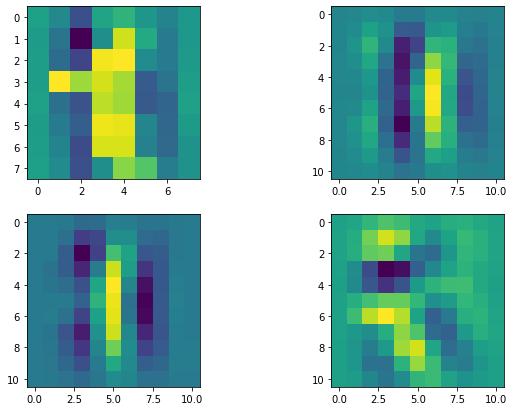

In [93]:
T = X[1]
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(T)
fig.add_subplot(2, 2, 2)
plt.imshow(convolve2d(T,filters[0]))
fig.add_subplot(2, 2, 3)
plt.imshow(convolve2d(T,filters[1]))
fig.add_subplot(2, 2, 4)
plt.imshow(convolve2d(T,filters[2]))

In [94]:
datasets = [X]
digits = load_digits()
for f in filters:
    Xf = []
    for im in X:
        Xf.append(convolve2d(im,f,'same'))
    datasets.append(Xf)


In [95]:
scaler = StandardScaler()
def rescale(collection):
    collection = np.reshape(collection,(1797,64))
    collection = scaler.fit_transform(collection)
    return np.reshape(collection,(1797,8,8))


In [96]:
for idx,D in enumerate(datasets):
    datasets[idx] = rescale(D)



In [97]:
B = 10
cubpers = gtda.homology.CubicalPersistence()
diagrams = cubpers.fit_transform(X)
persim  = gtda.diagrams.PersistenceImage(n_bins=B)
def im_2_persim(collection):
    diagrams = cubpers.fit_transform(collection)
    im = persim.fit_transform(diagrams)
    return np.reshape(im,(1797,2*B*B))

In [98]:
diagrams = []
for D in datasets:
    diagrams.append(im_2_persim(D))

In [104]:
total_diagrams = np.concatenate(diagrams,axis = 1)

In [105]:
#Load target data
from sklearn.preprocessing import OneHotEncoder
y = digits.target
enc = OneHotEncoder(sparse=False)
labels = enc.fit_transform(y.reshape(-1,1))

In [106]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(total_diagrams,labels, test_size=0.33, random_state=0)

In [107]:
#Model 1: KNN Classifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=13)
cv_results = cross_validate(neigh, total_diagrams, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.43739566 0.47245409 0.47579299]


In [108]:
#Model 2: Boosted Trees.
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators = 10,random_state = 0)
cv_results = cross_validate(gb_model, total_diagrams, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.61936561 0.61602671 0.60934891]


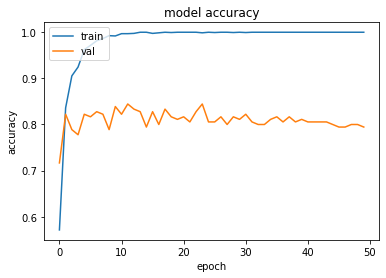

In [109]:
#Model 3: Deep Learning
from keras import models
from keras import layers
np.random.seed(0)
network = models.Sequential()
network.add(layers.Dense(units=100,input_dim = 2*(16+1)*B*B, activation='relu'))
network.add(layers.Dense(units=100, activation='relu'))
network.add(layers.Dense(units=10, activation='softmax'))
network.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
history = network.fit(total_diagrams, labels,validation_split = 0.1, epochs=50, batch_size=4,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

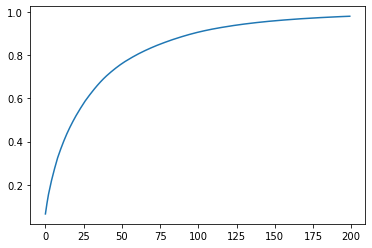

In [110]:
#Let's run these experiments again, now using PCA preprocessing
from sklearn.decomposition import PCA 
pca = PCA(n_components=200)
diagrams_pca = pca.fit_transform(total_diagrams)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [111]:
#Model 1: KNN Classifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
cv_results = cross_validate(neigh, diagrams_pca, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.40901503 0.42237062 0.42570952]


In [112]:
#Model 2: Boosted Trees.
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators = 10,random_state = 0)
cv_results = cross_validate(gb_model,diagrams_pca, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.36894825 0.39232053 0.42904841]


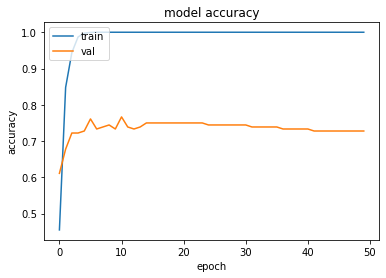

In [113]:
#Model 3: Deep Learning
from keras import models
from keras import layers
np.random.seed(0)
network = models.Sequential()
network.add(layers.Dense(units=100,input_dim = 200, activation='relu'))
network.add(layers.Dense(units=100, activation='relu'))
network.add(layers.Dense(units=10, activation='softmax'))
network.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
history = network.fit(diagrams_pca, labels,validation_split = 0.1, epochs=50, batch_size=4,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()